# What Determines the Likelihood of a Goal?

Football is the most popular sport in the world. In this report, we try to measure how goals impact games, using historical data from the 2015/2016 season of the English Premier League. We will predict which teams should've scored the most goals, and which the least. The raw data is extracted from 3 files which can be found on [Kaggle](https://www.kaggle.com/secareanualin/football-events/home).

# Data Exploration

In [348]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
events = pd.read_csv('events.csv')
ginf = pd.read_csv('ginf.csv')
datadict = pd.read_table('dictionary.txt', names=('num','events'))

In [3]:
events.head()

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,...,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",2,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
2,UFot0hit/,UFot0hit3,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",2,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
3,UFot0hit/,UFot0hit4,4,7,Foul by Sven Bender (Borussia Dortmund).,3,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
4,UFot0hit/,UFot0hit5,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,8,NaN,2,Hamburg SV,Borussia Dortmund,...,NaN,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0


The files we extracted the data from have data on 5 different leagues. Before conducting any sort of analysis we must first clean up our data so that we only have data on the Premier League, and only the data in the season 2015/2016. Our data also isn't in the right format, so we will create dictionaries of relevant data and organize these dictionaries into data frames.

In [4]:
ginf.head()

,id_odsp,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,D1,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
1,Aw5DflLH/,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,D1,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN
2,bkjpaC6n/,/soccer/germany/bundesliga-2011-2012/werder-br...,True,2011-08-06,D1,2012,germany,Werder Bremen,Kaiserslautern,2,0,1.83,4.20,4.80,NaN,NaN,NaN,NaN
3,CzPV312a/,/soccer/france/ligue-1-2011-2012/paris-sg-lori...,True,2011-08-06,F1,2012,france,Paris Saint-Germain,Lorient,0,1,1.55,4.50,9.40,NaN,NaN,NaN,NaN
4,GUOdmtII/,/soccer/france/ligue-1-2011-2012/caen-valencie...,True,2011-08-06,F1,2012,france,Caen,Valenciennes,1,0,2.50,3.40,3.45,NaN,NaN,NaN,NaN


In [5]:
league = {'E0':'English Premier League',
         'D1':'Bundesliga',
         'F1':'Ligue 1',
         'SP1':'La Liga',
         'I1':'Serie A'}

In [6]:
event_type=datadict[1:13]
event_type_2=datadict[14:18]
side=datadict[19:21]
shot_placement=datadict[22:35]
shot_outcome=datadict[36:40]
location=datadict[41:60]
bodypart=datadict[61:64]
assist_method=datadict[65:70]
situation=datadict[71:75]

In [7]:
shot_placement

,num,events
22,1,Bit too high
23,2,Blocked
24,3,Bottom left corner
25,4,Bottom right corner
26,5,Centre of the goal
27,6,High and wide
28,7,Hits the bar
29,8,Misses to the left
30,9,Misses to the right
31,10,Too high


In [8]:
match_events = {1:'Attempt', 2:'Corner', 3:'Foul',
               4:'Yellow card', 5:'Second yellow card', 6:'Red card',
               7:'Substitution', 8:'Free kick won', 9:'Offside',
               10:'Hand ball', 11:'Penalty conceded'}
more_match_events = {12:'Key Pass', 13:'Failed through ball', 14:'Sending off', 15:'Own goal'}
sides = {1:'Home', 2:'Away'}
shot_placements = {1:'Bit too high', 2:'Blocked',
                   3:'Bottom left corner', 4:'Bottom right corner',
                   5:'Centre of the goal', 6:'High and wide',
                   7:'Hits the bar', 8:'Misses to the left',
                   9:'Misses to the right', 10:'Too high',
                   11:'Top centre of the goal', 12:'Top left corner',
                   13:'Top right corner'}
shot_outcomes = {1:'On target', 2:'Off target', 3:'Blocked', 4:'Hit the bar'}
locations = {1:'Attacking half', 2:'Defensive half',
             3:'Centre of the box', 4:'Left wing',
             5:'Right wing', 6:'Difficult angle and long range',
             7:'Difficult angle on the left', 8:'Difficult angle on the right',
             9:'Left side of the box', 10:'Left side of the six yard box',
             11:'Right side of the box', 12:'Right side of the six yard box',
             13:'Very close range', 14:'Penalty spot',
             15:'Outside the box', 16:'Long range',
             17:'More than 35 yards', 18:'More than 40 yards',
             19:'Not recorded'}
scoring_methods = {1:'right foot', 2:'left foot', 3:'head'}
assist_methods = {0:np.nan, 1:'Pass', 2:'Cross', 3:'Headed pass', 4:'Through ball'}
situations = {1:'Open play', 2:'Set piece', 3:'Corner', 4:'Free kick'}

In [9]:
events['event_type'] = events['event_type'].map(match_events)
events['event_type2'] = events['event_type2'].map(more_match_events)
events['side'] = events['side'].map(sides)
events['shot_place'] = events['shot_place'].map(shot_placements)
events['shot_outcome']= events['shot_outcome'].map(shot_outcomes)
events['location'] = events['location'].map(locations)
events['bodypart'] = events['bodypart'].map(scoring_methods)
events['assist_method']= events['assist_method'].map(assist_methods)
events['situation'] = events['situation'].map(situations)

In [10]:
events.head()

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,Attempt,Key Pass,Away,Hamburg SV,Borussia Dortmund,...,NaN,NaN,High and wide,Off target,0,Left side of the box,left foot,Pass,Open play,0
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",Corner,NaN,Home,Borussia Dortmund,Hamburg SV,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
2,UFot0hit/,UFot0hit3,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",Corner,NaN,Home,Borussia Dortmund,Hamburg SV,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
3,UFot0hit/,UFot0hit4,4,7,Foul by Sven Bender (Borussia Dortmund).,Foul,NaN,Home,Borussia Dortmund,Hamburg SV,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
4,UFot0hit/,UFot0hit5,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,Free kick won,NaN,Away,Hamburg SV,Borussia Dortmund,...,NaN,NaN,NaN,NaN,0,Defensive half,NaN,NaN,NaN,0


In [11]:
ginf['league'] = ginf['league'].map(league)

In [12]:
ginf.head()

,id_odsp,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,Bundesliga,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
1,Aw5DflLH/,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,Bundesliga,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN
2,bkjpaC6n/,/soccer/germany/bundesliga-2011-2012/werder-br...,True,2011-08-06,Bundesliga,2012,germany,Werder Bremen,Kaiserslautern,2,0,1.83,4.20,4.80,NaN,NaN,NaN,NaN
3,CzPV312a/,/soccer/france/ligue-1-2011-2012/paris-sg-lori...,True,2011-08-06,Ligue 1,2012,france,Paris Saint-Germain,Lorient,0,1,1.55,4.50,9.40,NaN,NaN,NaN,NaN
4,GUOdmtII/,/soccer/france/ligue-1-2011-2012/caen-valencie...,True,2011-08-06,Ligue 1,2012,france,Caen,Valenciennes,1,0,2.50,3.40,3.45,NaN,NaN,NaN,NaN


In [13]:
all_data = events.merge(ginf,how='left')

In [14]:
all_data.head()

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,Attempt,Key Pass,Away,Hamburg SV,Borussia Dortmund,...,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",Corner,NaN,Home,Borussia Dortmund,Hamburg SV,...,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
2,UFot0hit/,UFot0hit3,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",Corner,NaN,Home,Borussia Dortmund,Hamburg SV,...,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
3,UFot0hit/,UFot0hit4,4,7,Foul by Sven Bender (Borussia Dortmund).,Foul,NaN,Home,Borussia Dortmund,Hamburg SV,...,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
4,UFot0hit/,UFot0hit5,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,Free kick won,NaN,Away,Hamburg SV,Borussia Dortmund,...,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN


We have 5 different leagues, but we are only interested in the Premier League. We will focus on the 2015/2016 season. This season was significant in that the championship was won by Leicester City, a team that had barely survived relegation the previous season, thus breaking the top 6 hegemony. We will predict the results of each game based on attempts on target to try and determine who should win the league title. We will also determine the best area of the pitch to shoot from, and the best location to place it.

In [15]:
prem = all_data[(all_data['league']=='English Premier League') & 
                (all_data['season']== 2016) &
               (all_data['event_type']=='Attempt')]

In [16]:
prem.head()

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
662450,bRrgEJw3/,bRrgEJw314,14,20,Attempt missed. Marc Pugh (Bournemouth) header...,Attempt,Key Pass,Home,Bournemouth,Aston Villa,...,Aston Villa,0,1,2.03,3.95,4.9,NaN,NaN,NaN,NaN
662454,bRrgEJw3/,bRrgEJw318,18,24,Attempt missed. Matt Ritchie (Bournemouth) lef...,Attempt,Key Pass,Home,Bournemouth,Aston Villa,...,Aston Villa,0,1,2.03,3.95,4.9,NaN,NaN,NaN,NaN
662458,bRrgEJw3/,bRrgEJw322,22,27,Attempt missed. Idrissa Gueye (Aston Villa) ri...,Attempt,Key Pass,Away,Aston Villa,Bournemouth,...,Aston Villa,0,1,2.03,3.95,4.9,NaN,NaN,NaN,NaN
662459,bRrgEJw3/,bRrgEJw323,23,29,Attempt blocked. Joshua King (Bournemouth) rig...,Attempt,Key Pass,Home,Bournemouth,Aston Villa,...,Aston Villa,0,1,2.03,3.95,4.9,NaN,NaN,NaN,NaN
662462,bRrgEJw3/,bRrgEJw326,26,33,Attempt missed. Andrew Surman (Bournemouth) le...,Attempt,Key Pass,Home,Bournemouth,Aston Villa,...,Aston Villa,0,1,2.03,3.95,4.9,NaN,NaN,NaN,NaN


In [17]:
feat_cols = ['id_odsp', 'event_team','opponent','odd_h', 'odd_d', 'odd_a', 
             'assist_method', 'location', 
             'side', 'shot_place', 'situation', 
             'bodypart', 'is_goal','time','fthg','ftag']
rel_prem_data = prem[feat_cols]
arsenal = prem[(prem['event_team'] == 'Arsenal') | (prem['opponent'] == 'Arsenal')][feat_cols]
villa = prem[(prem['event_team'] == 'Aston Villa') | (prem['opponent'] == 'Aston Villa')][feat_cols]
bournemouth = prem[(prem['event_team'] == 'Bournemouth') | (prem['opponent'] == 'Bournemouth')][feat_cols]
chelsea = prem[(prem['event_team'] == 'Chelsea') | (prem['opponent'] == 'Chelsea')][feat_cols]
palace = prem[(prem['event_team'] == 'Crystal Palace') | (prem['opponent'] == 'Crystal Palace')][feat_cols]
everton = prem[(prem['event_team'] == 'Everton') | (prem['opponent'] == 'Everton')][feat_cols]
lcfc = prem[(prem['event_team'] == 'Leicester City') | (prem['opponent'] == 'Leicester City')][feat_cols]
liverpool = prem[(prem['event_team'] == 'Liverpool') | (prem['opponent'] == 'Liverpool')][feat_cols]
mancity = prem[(prem['event_team'] == 'Manchester City') | (prem['opponent'] == 'Manchester City')][feat_cols]
manutd = prem[(prem['event_team'] == 'Manchester Utd') | (prem['opponent'] == 'Manchester Utd')][feat_cols]
newcastle = prem[(prem['event_team'] == 'Newcastle') | (prem['opponent'] == 'Newcastle')][feat_cols]
norwich = prem[(prem['event_team'] == 'Norwich City') | (prem['opponent'] == 'Norwich City')][feat_cols]
southampton = prem[(prem['event_team'] == 'Southampton') | (prem['opponent'] == 'Southampton')][feat_cols]
stoke = prem[(prem['event_team'] == 'Stoke City') | (prem['opponent'] == 'Stoke City')][feat_cols]
sunderland = prem[(prem['event_team'] == 'Sunderland') | (prem['opponent'] == 'Sunderland')][feat_cols]
swansea = prem[(prem['event_team'] == 'Swansea') | (prem['opponent'] == 'Swansea')][feat_cols]
spurs = prem[(prem['event_team'] == 'Tottenham') | (prem['opponent'] == 'Tottenham')][feat_cols]
watford = prem[(prem['event_team'] == 'Watford') | (prem['opponent'] == 'Watford')][feat_cols]
west_brom = prem[(prem['event_team'] == 'West Brom') | (prem['opponent'] == 'West Brom')][feat_cols]
west_ham = prem[(prem['event_team'] == 'West Ham') | (prem['opponent'] == 'West Ham')][feat_cols]

We now have all events that occured in every game in the 2015/2016 season that led to potential goals. We can use this to predict how many goals a team could score per game, whether they'd win or not, and what position they'd finish the league season in.

In [18]:
match_day = rel_prem_data.groupby('id_odsp')

In [19]:
matches = [match_day.get_group(x) for x in match_day.groups]

In [20]:
goals = {'Arsenal': 0, 'Aston Villa': 0,'Bournemouth': 0,'Chelsea': 0,'Crystal Palace': 0,
         'Everton': 0,'Leicester City': 0,'Liverpool': 0,'Manchester City': 0,'Manchester Utd': 0,
         'Newcastle': 0,'Norwich City': 0,'Southampton': 0,'Stoke City': 0,'Sunderland': 0,
         'Swansea': 0, 'Tottenham': 0,'Watford': 0,'West Brom': 0,'West Ham': 0}
conceded = {'Arsenal': 0, 'Aston Villa': 0,'Bournemouth': 0,'Chelsea': 0,'Crystal Palace': 0,
         'Everton': 0,'Leicester City': 0,'Liverpool': 0,'Manchester City': 0,'Manchester Utd': 0,
         'Newcastle': 0,'Norwich City': 0,'Southampton': 0,'Stoke City': 0,'Sunderland': 0,
         'Swansea': 0, 'Tottenham': 0,'Watford': 0,'West Brom': 0,'West Ham': 0}

In [21]:
for match in matches:
    if match.iloc[0]['side'] == 'Home':
        goals[match.iloc[0]['event_team']] += match.iloc[0]['fthg']
        goals[match.iloc[0]['opponent']] += match.iloc[0]['ftag']
        conceded[match.iloc[0]['event_team']] += match.iloc[0]['ftag']
        conceded[match.iloc[0]['opponent']] += match.iloc[0]['fthg']
    else:
        goals[match.iloc[0]['event_team']] += match.iloc[0]['ftag']
        goals[match.iloc[0]['opponent']] += match.iloc[0]['fthg']
        conceded[match.iloc[0]['event_team']] += match.iloc[0]['ftag']
        conceded[match.iloc[0]['opponent']] += match.iloc[0]['fthg']

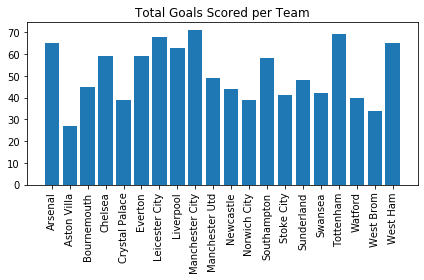

In [22]:
plt.bar(range(len(goals)), list(goals.values()))
plt.title('Total Goals Scored per Team')
plt.xticks(range(len(goals)), list(goals.keys()), rotation = 90)
plt.tick_params(axis='x', which='major', labelsize= 10)
plt.tight_layout()
plt.show()

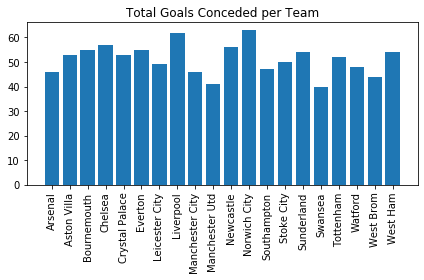

In [23]:
plt.bar(range(len(conceded)), list(conceded.values()))
plt.title('Total Goals Conceded per Team')
plt.xticks(range(len(conceded)), list(conceded.keys()), rotation = 90)
plt.tick_params(axis='x', which='major', labelsize= 10)
plt.tight_layout()
plt.show()

Above, we have 2 plots of the actual goals scored and conceded by each team. Now we need to predict how many each team would've scored, based on their chances in each game. We will try to do this through Logistic Regression.

# Logistic Regression

In [24]:
rel_prem_data.groupby(['bodypart', 'is_goal'], sort=False).size().reset_index(name='Count')
arsenal.groupby(['bodypart', 'is_goal'], sort=False).size().reset_index(name='Count')
villa.groupby(['bodypart', 'is_goal'], sort=False).size().reset_index(name='Count')
bournemouth.groupby(['bodypart', 'is_goal'], sort=False).size().reset_index(name='Count')
chelsea.groupby(['bodypart', 'is_goal'], sort=False).size().reset_index(name='Count')
palace.groupby(['bodypart', 'is_goal'], sort=False).size().reset_index(name='Count')
everton.groupby(['bodypart', 'is_goal'], sort=False).size().reset_index(name='Count')
lcfc.groupby(['bodypart', 'is_goal'], sort=False).size().reset_index(name='Count')
liverpool.groupby(['bodypart', 'is_goal'], sort=False).size().reset_index(name='Count')
mancity.groupby(['bodypart', 'is_goal'], sort=False).size().reset_index(name='Count')
manutd.groupby(['bodypart', 'is_goal'], sort=False).size().reset_index(name='Count')
newcastle.groupby(['bodypart', 'is_goal'], sort=False).size().reset_index(name='Count')
norwich.groupby(['bodypart', 'is_goal'], sort=False).size().reset_index(name='Count')
southampton.groupby(['bodypart', 'is_goal'], sort=False).size().reset_index(name='Count')
stoke.groupby(['bodypart', 'is_goal'], sort=False).size().reset_index(name='Count')
sunderland.groupby(['bodypart', 'is_goal'], sort=False).size().reset_index(name='Count')
swansea.groupby(['bodypart', 'is_goal'], sort=False).size().reset_index(name='Count')
spurs.groupby(['bodypart', 'is_goal'], sort=False).size().reset_index(name='Count')
watford.groupby(['bodypart', 'is_goal'], sort=False).size().reset_index(name='Count')
west_brom.groupby(['bodypart', 'is_goal'], sort=False).size().reset_index(name='Count')
west_ham.groupby(['bodypart', 'is_goal'], sort=False).size().reset_index(name='Count')

,bodypart,is_goal,Count
0,left foot,0,233
1,head,0,152
2,right foot,0,567
3,head,1,19
4,right foot,1,72
5,left foot,1,25


In [78]:
train_ft = rel_prem_data.drop(columns = ['id_odsp','event_team','opponent','is_goal','time','fthg','ftag','odd_h','odd_d','odd_a'])
train_ft_ars = arsenal.drop(columns = ['id_odsp','event_team','opponent','is_goal','time','fthg','ftag','odd_h','odd_d','odd_a'])
train_ft_villa = villa.drop(columns = ['id_odsp','event_team','opponent','is_goal','time','fthg','ftag','odd_h','odd_d','odd_a'])
train_ft_bmouth = bournemouth.drop(columns = ['id_odsp','event_team','opponent','is_goal','time','fthg','ftag','odd_h','odd_d','odd_a'])
train_ft_che = chelsea.drop(columns = ['id_odsp','event_team','opponent','is_goal','time','fthg','ftag','odd_h','odd_d','odd_a'])
train_ft_cry = palace.drop(columns = ['id_odsp','event_team','opponent','is_goal','time','fthg','ftag','odd_h','odd_d','odd_a'])
train_ft_eve = everton.drop(columns = ['id_odsp','event_team','opponent','is_goal','time','fthg','ftag','odd_h','odd_d','odd_a'])
train_ft_lcfc = lcfc.drop(columns = ['id_odsp','event_team','opponent','is_goal','time','fthg','ftag','odd_h','odd_d','odd_a'])
train_ft_lpool = liverpool.drop(columns = ['id_odsp','event_team','opponent','is_goal','time','fthg','ftag','odd_h','odd_d','odd_a'])
train_ft_mcfc = mancity.drop(columns = ['id_odsp','event_team','opponent','is_goal','time','fthg','ftag','odd_h','odd_d','odd_a'])
train_ft_manutd = manutd.drop(columns = ['id_odsp','event_team','opponent','is_goal','time','fthg','ftag','odd_h','odd_d','odd_a'])
train_ft_nufc = newcastle.drop(columns = ['id_odsp','event_team','opponent','is_goal','time','fthg','ftag','odd_h','odd_d','odd_a'])
train_ft_ncfc = norwich.drop(columns = ['id_odsp','event_team','opponent','is_goal','time','fthg','ftag','odd_h','odd_d','odd_a'])
train_ft_soton = southampton.drop(columns = ['id_odsp','event_team','opponent','is_goal','time','fthg','ftag','odd_h','odd_d','odd_a'])
train_ft_stk = stoke.drop(columns = ['id_odsp','event_team','opponent','is_goal','time','fthg','ftag','odd_h','odd_d','odd_a'])
train_ft_sun = sunderland.drop(columns = ['id_odsp','event_team','opponent','is_goal','time','fthg','ftag','odd_h','odd_d','odd_a'])
train_ft_swa = swansea.drop(columns = ['id_odsp','event_team','opponent','is_goal','time','fthg','ftag','odd_h','odd_d','odd_a'])
train_ft_spurs = spurs.drop(columns = ['id_odsp','event_team','opponent','is_goal','time','fthg','ftag','odd_h','odd_d','odd_a'])
train_ft_wat = watford.drop(columns = ['id_odsp','event_team','opponent','is_goal','time','fthg','ftag','odd_h','odd_d','odd_a'])
train_ft_wba = west_brom.drop(columns = ['id_odsp','event_team','opponent','is_goal','time','fthg','ftag','odd_h','odd_d','odd_a'])
train_ft_whu = west_ham.drop(columns = ['id_odsp','event_team','opponent','is_goal','time','fthg','ftag','odd_h','odd_d','odd_a'])
train_tgt = rel_prem_data['is_goal']
train_tgt_ars = arsenal['is_goal']
train_tgt_villa = villa['is_goal']
train_tgt_bmouth = bournemouth['is_goal']
train_tgt_che = chelsea['is_goal']
train_tgt_cry = palace['is_goal']
train_tgt_eve = everton['is_goal']
train_tgt_lcfc = lcfc['is_goal']
train_tgt_lpool = liverpool['is_goal']
train_tgt_mcfc = mancity['is_goal']
train_tgt_manutd = manutd['is_goal']
train_tgt_nufc = newcastle['is_goal']
train_tgt_ncfc = norwich['is_goal']
train_tgt_soton = southampton['is_goal']
train_tgt_stk = stoke['is_goal']
train_tgt_sun = sunderland['is_goal']
train_tgt_swa = swansea['is_goal']
train_tgt_spurs = spurs['is_goal']
train_tgt_wat = watford['is_goal']
train_tgt_wba = west_brom['is_goal']
train_tgt_whu = west_ham['is_goal']

h_a = {'Home': 1,'Away':0}
train_ft.side.replace(h_a,inplace=True)
train_ft_ars.side.replace(h_a,inplace=True)
train_ft_villa.side.replace(h_a,inplace=True)
train_ft_bmouth.side.replace(h_a,inplace=True)
train_ft_che.side.replace(h_a,inplace=True)
train_ft_cry.side.replace(h_a,inplace=True)
train_ft_eve.side.replace(h_a,inplace=True)
train_ft_lcfc.side.replace(h_a,inplace=True)
train_ft_lpool.side.replace(h_a,inplace=True)
train_ft_mcfc.side.replace(h_a,inplace=True)
train_ft_manutd.side.replace(h_a,inplace=True)
train_ft_nufc.side.replace(h_a,inplace=True)
train_ft_ncfc.side.replace(h_a,inplace=True)
train_ft_soton.side.replace(h_a,inplace=True)
train_ft_stk.side.replace(h_a,inplace=True)
train_ft_sun.side.replace(h_a,inplace=True)
train_ft_swa.side.replace(h_a,inplace=True)
train_ft_spurs.side.replace(h_a,inplace=True)
train_ft_wat.side.replace(h_a,inplace=True)
train_ft_wba.side.replace(h_a,inplace=True)
train_ft_whu.side.replace(h_a,inplace=True)

In [79]:
rel_columns = ['side', 'assist_method_Cross',
       'assist_method_Headed pass', 'assist_method_Pass',
       'assist_method_Through ball', 'location_Centre of the box',
       'location_Difficult angle and long range',
       'location_Difficult angle on the left',
       'location_Difficult angle on the right',
       'location_Left side of the box',
       'location_Left side of the six yard box', 'location_Long range',
       'location_More than 35 yards', 'location_More than 40 yards',
       'location_Not recorded', 'location_Outside the box',
       'location_Penalty spot', 'location_Right side of the box',
       'location_Right side of the six yard box', 'location_Very close range',
       'shot_place_Bit too high', 'shot_place_Blocked',
       'shot_place_Bottom left corner', 'shot_place_Bottom right corner',
       'shot_place_Centre of the goal', 'shot_place_High and wide',
       'shot_place_Hits the bar', 'shot_place_Misses to the left',
       'shot_place_Misses to the right', 'shot_place_Too high',
       'shot_place_Top centre of the goal', 'shot_place_Top left corner',
       'shot_place_Top right corner', 'situation_Corner',
       'situation_Free kick', 'situation_Open play', 'situation_Set piece',
       'bodypart_head', 'bodypart_left foot', 'bodypart_right foot']
dummies = pd.get_dummies(train_ft)

dummies_ars = pd.get_dummies(train_ft_ars, prefix = '', prefix_sep= '')
dummies_ars = dummies_ars.T.reindex(rel_columns).fillna(0)

dummies_villa = pd.get_dummies(train_ft_villa, prefix = '', prefix_sep= '')
dummies_villa = dummies_villa.T.reindex(rel_columns).fillna(0)

dummies_bmouth = pd.get_dummies(train_ft_bmouth, prefix = '', prefix_sep= '')
dummies_bmouth = dummies_bmouth.T.reindex(rel_columns).fillna(0)

dummies_che = pd.get_dummies(train_ft_che, prefix = '', prefix_sep= '')
dummies_che = dummies_che.T.reindex(rel_columns).fillna(0)

dummies_cry = pd.get_dummies(train_ft_cry, prefix = '', prefix_sep= '')
dummies_cry = dummies_cry.T.reindex(rel_columns).fillna(0)

dummies_eve = pd.get_dummies(train_ft_eve, prefix = '', prefix_sep= '')
dummies_eve = dummies_eve.T.reindex(rel_columns).fillna(0)

dummies_lcfc = pd.get_dummies(train_ft_lcfc, prefix = '', prefix_sep= '')
dummies_lcfc = dummies_lcfc.T.reindex(rel_columns).fillna(0)

dummies_lpool = pd.get_dummies(train_ft_lpool, prefix = '', prefix_sep= '')
dummies_lpool = dummies_lpool.T.reindex(rel_columns).fillna(0)

dummies_mcfc = pd.get_dummies(train_ft_mcfc, prefix = '', prefix_sep= '')
dummies_mcfc = dummies_mcfc.T.reindex(rel_columns).fillna(0)

dummies_manutd = pd.get_dummies(train_ft_manutd, prefix = '', prefix_sep= '')
dummies_manutd = dummies_manutd.T.reindex(rel_columns).fillna(0)

dummies_nufc = pd.get_dummies(train_ft_nufc, prefix = '', prefix_sep= '')
dummies_nufc = dummies_nufc.T.reindex(rel_columns).fillna(0)

dummies_ncfc = pd.get_dummies(train_ft_ncfc, prefix = '', prefix_sep= '')
dummies_ncfc = dummies_ncfc.T.reindex(rel_columns).fillna(0)

dummies_soton = pd.get_dummies(train_ft_soton, prefix = '', prefix_sep= '')
dummies_soton = dummies_soton.T.reindex(rel_columns).fillna(0)

dummies_stk = pd.get_dummies(train_ft_stk, prefix = '', prefix_sep= '')
dummies_stk = dummies_stk.T.reindex(rel_columns).fillna(0)

dummies_sun = pd.get_dummies(train_ft_sun, prefix = '', prefix_sep= '')
dummies_sun = dummies_sun.T.reindex(rel_columns).fillna(0)

dummies_swa = pd.get_dummies(train_ft_swa, prefix = '', prefix_sep= '')
dummies_swa = dummies_swa.T.reindex(rel_columns).fillna(0)

dummies_spurs = pd.get_dummies(train_ft_spurs, prefix = '', prefix_sep='')
dummies_spurs = dummies_spurs.T.reindex(rel_columns).fillna(0)

dummies_wat = pd.get_dummies(train_ft_wat, prefix = '', prefix_sep= '')
dummies_wat = dummies_wat.T.reindex(rel_columns).fillna(0)

dummies_wba = pd.get_dummies(train_ft_wba, prefix = '', prefix_sep= '')
dummies_wba = dummies_wba.T.reindex(rel_columns).fillna(0)

dummies_whu = pd.get_dummies(train_ft_whu, prefix = '', prefix_sep= '')
dummies_whu = dummies_whu.T.reindex(rel_columns).fillna(0)

In [80]:
x_train, x_test, y_train, y_test = train_test_split(dummies, train_tgt,
                                                    test_size = .2)
x_train_ars, x_test_ars, y_train_ars, y_test_ars = train_test_split(dummies_ars.T, train_tgt_ars,
                                                    test_size = .2)
x_train_avl, x_test_avl, y_train_avl, y_test_avl = train_test_split(dummies_villa.T, train_tgt_villa,
                                                    test_size = .2)
x_train_bmouth, x_test_bmouth, y_train_bmouth, y_test_bmouth = train_test_split(dummies_bmouth.T, train_tgt_bmouth,
                                                    test_size = .2)
x_train_che, x_test_che, y_train_che, y_test_che = train_test_split(dummies_che.T, train_tgt_che,
                                                    test_size = .2)
x_train_cry, x_test_cry, y_train_cry, y_test_cry = train_test_split(dummies_cry.T, train_tgt_cry,
                                                    test_size = .2)
x_train_eve, x_test_eve, y_train_eve, y_test_eve = train_test_split(dummies_eve.T, train_tgt_eve,
                                                    test_size = .2)
x_train_lcfc, x_test_lcfc, y_train_lcfc, y_test_lcfc = train_test_split(dummies_lcfc.T, train_tgt_lcfc,
                                                    test_size = .2)
x_train_lpool, x_test_lpool, y_train_lpool, y_test_lpool = train_test_split(dummies_lpool.T, train_tgt_lpool,
                                                    test_size = .2)
x_train_mcfc, x_test_mcfc, y_train_mcfc, y_test_mcfc = train_test_split(dummies_mcfc.T, train_tgt_mcfc,
                                                    test_size = .2)
x_train_manutd, x_test_manutd, y_train_manutd, y_test_manutd = train_test_split(dummies_manutd.T, train_tgt_manutd,
                                                    test_size = .2)
x_train_nufc, x_test_nufc, y_train_nufc, y_test_nufc = train_test_split(dummies_nufc.T, train_tgt_nufc,
                                                    test_size = .2)
x_train_ncfc, x_test_ncfc, y_train_ncfc, y_test_ncfc = train_test_split(dummies_ncfc.T, train_tgt_ncfc,
                                                    test_size = .2)
x_train_soton, x_test_soton, y_train_soton, y_test_soton = train_test_split(dummies_soton.T, train_tgt_soton,
                                                    test_size = .2)
x_train_stk, x_test_stk, y_train_stk, y_test_stk = train_test_split(dummies_stk.T, train_tgt_stk,
                                                    test_size = .2)
x_train_sun, x_test_sun, y_train_sun, y_test_sun = train_test_split(dummies_sun.T, train_tgt_sun,
                                                    test_size = .2)
x_train_swa, x_test_swa, y_train_swa, y_test_swa = train_test_split(dummies_swa.T, train_tgt_swa,
                                                    test_size = .2)
x_train_spurs, x_test_spurs, y_train_spurs, y_test_spurs = train_test_split(dummies_spurs.T, train_tgt_spurs,
                                                    test_size = .2)
x_train_wat, x_test_wat, y_train_wat, y_test_wat = train_test_split(dummies_wat.T, train_tgt_wat,
                                                    test_size = .2)
x_train_wba, x_test_wba, y_train_wba, y_test_wba = train_test_split(dummies_wba.T, train_tgt_wba,
                                                    test_size = .2)
x_train_whu, x_test_whu, y_train_whu, y_test_whu = train_test_split(dummies_whu.T, train_tgt_whu,
                                                    test_size = .2)

In [81]:
x_train.shape

(7807, 40)

In [82]:
model = LogisticRegression(max_iter = 1000)
model.fit(x_train,y_train)
pred = model.predict(x_test)

model_ars = LogisticRegression()
model_ars.fit(x_train_ars,y_train_ars)
pred_ars = model_ars.predict(x_test_ars)

model_villa = LogisticRegression()
model_villa.fit(x_train_avl,y_train_avl)
pred_villa = model_villa.predict(x_test_avl)

model_bmouth = LogisticRegression()
model_bmouth.fit(x_train_bmouth,y_train_bmouth)
pred_bmouth = model_bmouth.predict(x_test_bmouth)

model_che = LogisticRegression()
model_che.fit(x_train_che,y_train_che)
pred_che = model_che.predict(x_test_che)

model_cry = LogisticRegression()
model_cry.fit(x_train_cry,y_train_cry)
pred_cry = model_cry.predict(x_test_cry)

model_eve = LogisticRegression()
model_eve.fit(x_train_eve,y_train_eve)
pred_eve = model_eve.predict(x_test_eve)

model_lcfc = LogisticRegression()
model_lcfc.fit(x_train_lcfc,y_train_lcfc)
pred_lcfc = model_lcfc.predict(x_test_lcfc)

model_lpool = LogisticRegression()
model_lpool.fit(x_train_lpool,y_train_lpool)
pred_lpool = model_lpool.predict(x_test_lpool)

model_mcfc = LogisticRegression()
model_mcfc.fit(x_train_mcfc,y_train_mcfc)
pred_mcfc = model_mcfc.predict(x_test_mcfc)

model_manutd = LogisticRegression()
model_manutd.fit(x_train_manutd,y_train_manutd)
pred_manutd = model_manutd.predict(x_test_manutd)

model_nufc = LogisticRegression()
model_nufc.fit(x_train_nufc,y_train_nufc)
pred_nufc = model_nufc.predict(x_test_nufc)

model_ncfc = LogisticRegression()
model_ncfc.fit(x_train_ncfc,y_train_ncfc)
pred_ncfc = model_ncfc.predict(x_test_ncfc)

model_soton = LogisticRegression()
model_soton.fit(x_train_soton,y_train_soton)
pred_soton = model_soton.predict(x_test_soton)

model_stk = LogisticRegression()
model_stk.fit(x_train_stk,y_train_stk)
pred_stk = model_stk.predict(x_test_stk)

model_sun = LogisticRegression()
model_sun.fit(x_train_sun,y_train_sun)
pred_sun = model_sun.predict(x_test_sun)

model_swa = LogisticRegression()
model_swa.fit(x_train_swa,y_train_swa)
pred_swa = model_swa.predict(x_test_swa)

model_spurs = LogisticRegression()
model_spurs.fit(x_train_spurs,y_train_spurs)
pred_spurs = model_spurs.predict(x_test_spurs)

model_wat = LogisticRegression()
model_wat.fit(x_train_wat,y_train_wat)
pred_wat = model_wat.predict(x_test_wat)

model_wba = LogisticRegression()
model_wba.fit(x_train_wba,y_train_wba)
pred_wba = model_wba.predict(x_test_wba)

model_whu = LogisticRegression()
model_whu.fit(x_train_whu,y_train_whu)
pred_whu = model_whu.predict(x_test_whu)


In [83]:
print('Accuracy: ', accuracy_score(y_test, pred))
print('Accuracy: ', accuracy_score(y_test_bmouth,pred_bmouth))

Accuracy:  0.9318647540983607
Accuracy:  0.8833333333333333


Our full model is almost 93% accurate. This number doesn't mean much since football is a low scoring game. Most of the correct predictions would be where the model predicted no goal and no goal was scored. A confusion matrix explains this well, as shown below. As an example we provided the accuracy of the Bournemouth model as well. Like all other team models, the Bournemouth model too is less accurate than the full model. In fact, as we will find out soon, the expected goals for every team is far from their actual goals scored, while the full model's expected goals was relatively close to the actual goals scored.

In [84]:
print(confusion_matrix(y_test,pred))

[[1697   37]
 [  96  122]]


As predicted, most of the correct predictions are the no goals. 1697 non-goals were correctly predicted, and 37 goals were predicted but not scored. 96 goals that we predicted wouldn't be actually were, while 122 goals were correctly predicted.

In [96]:
expected_goals = {'Arsenal': 0, 'Aston Villa': 0,'Bournemouth': 0,'Chelsea': 0,'Crystal Palace': 0,
         'Everton': 0,'Leicester City': 0,'Liverpool': 0,'Manchester City': 0,'Manchester Utd': 0,
         'Newcastle': 0,'Norwich City': 0,'Southampton': 0,'Stoke City': 0,'Sunderland': 0,
         'Swansea': 0, 'Tottenham': 0,'Watford': 0,'West Brom': 0,'West Ham': 0}

expected_goals['Arsenal'] = model_ars.predict_proba(
    dummies_ars.T)[:,1].mean()*len(dummies_ars.T[(dummies_ars != 0).any()])
expected_goals['Aston Villa'] = model_villa.predict_proba(
    dummies_villa.T)[:,1].mean()*len(dummies_villa.T[(dummies_villa != 0).any()])
expected_goals['Bournemouth'] = model_bmouth.predict_proba(
    dummies_bmouth.T)[:,1].mean()*len(dummies_bmouth.T[(dummies_bmouth != 0).any()])
expected_goals['Chelsea'] = model_che.predict_proba(
    dummies_che.T)[:,1].mean()*len(dummies_che.T[(dummies_che != 0).any()])
expected_goals['Crystal Palace'] = model_cry.predict_proba(
    dummies_cry.T)[:,1].mean()*len(dummies_cry.T[(dummies_cry != 0).any()])
expected_goals['Everton'] = model_eve.predict_proba(
    dummies_eve.T)[:,1].mean()*len(dummies_eve.T[(dummies_eve != 0).any()])
expected_goals['Leicester City'] = model_lcfc.predict_proba(
    dummies_lcfc.T)[:,1].mean()*len(dummies_lcfc.T[(dummies_lcfc != 0).any()])
expected_goals['Liverpool'] = model_lpool.predict_proba(
    dummies_lpool.T)[:,1].mean()*len(dummies_lpool.T[(dummies_lpool != 0).any()])
expected_goals['Manchester City'] = model_mcfc.predict_proba(
    dummies_mcfc.T)[:,1].mean()*len(dummies_mcfc.T[(dummies_mcfc != 0).any()])
expected_goals['Manchester Utd'] = model_manutd.predict_proba(
    dummies_manutd.T)[:,1].mean()*len(dummies_manutd.T[(dummies_manutd != 0).any()])
expected_goals['Newcastle'] = model_nufc.predict_proba(
    dummies_nufc.T)[:,1].mean()*len(dummies_nufc.T[(dummies_nufc != 0).any()])
expected_goals['Norwich City'] = model_ncfc.predict_proba(
    dummies_ncfc.T)[:,1].mean()*len(dummies_ncfc.T[(dummies_ncfc != 0).any()])
expected_goals['Southampton'] = model_soton.predict_proba(
    dummies_soton.T)[:,1].mean()*len(dummies_soton.T[(dummies_soton != 0).any()])
expected_goals['Stoke City'] = model_stk.predict_proba(
    dummies_stk.T)[:,1].mean()*len(dummies_stk.T[(dummies_stk != 0).any()])
expected_goals['Sunderland'] = model_sun.predict_proba(
    dummies_sun.T)[:,1].mean()*len(dummies_sun.T[(dummies_sun != 0).any()])
expected_goals['Swansea'] = model_swa.predict_proba(
    dummies_swa.T)[:,1].mean()*len(dummies_swa.T[(dummies_swa != 0).any()])
expected_goals['Tottenham'] = model_spurs.predict_proba(
    dummies_spurs.T)[:,1].mean()*len(dummies_spurs.T[(dummies_spurs != 0).any()])
expected_goals['Watford'] = model_wat.predict_proba(
    dummies_wat.T)[:,1].mean()*len(dummies_wat.T[(dummies_wat != 0).any()])
expected_goals['West Brom'] = model_wba.predict_proba(
    dummies_wba.T)[:,1].mean()*len(dummies_wba.T[(dummies_wba != 0).any()])
expected_goals['West Ham'] = model_whu.predict_proba(
    dummies_whu.T)[:,1].mean()*len(dummies_whu.T[(dummies_whu != 0).any()])

In [417]:
print(sum(expected_goals.values()))
expected_goals

1169.7477421249077


{'Arsenal': 57.06372499857061,
 'Aston Villa': 61.42453915041815,
 'Bournemouth': 60.776401975234684,
 'Chelsea': 67.53894756120174,
 'Crystal Palace': 47.315518389891,
 'Everton': 67.47514700262879,
 'Leicester City': 53.08244348856965,
 'Liverpool': 68.64451175122888,
 'Manchester City': 61.41379692140441,
 'Manchester Utd': 49.336831646796355,
 'Newcastle': 64.68476884274472,
 'Norwich City': 64.03405955415246,
 'Southampton': 53.059504245819916,
 'Stoke City': 55.098146896259564,
 'Sunderland': 60.680339673254515,
 'Swansea': 50.39787053369903,
 'Tottenham': 61.55146450968407,
 'Watford': 54.580247486582245,
 'West Brom': 45.59310302531852,
 'West Ham': 65.9963744714486}

Our regression model predicted Liverpool would've scored the most goals in the season with about 69 goals. West Brom would've scored the least with about 46 goals. This model suggests Manchester United got closest to their expected goals, with them scoring 49 against an expected 49.3. We will now use another classification model and see if we get similar results. We will use the KNN classifier model.

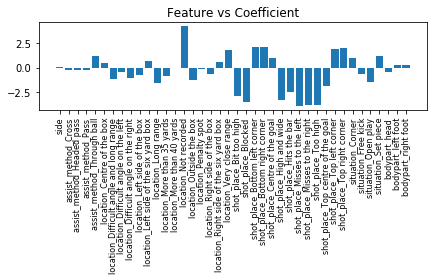

In [411]:
coef_dict = {}
for coef, feat in zip(model.coef_[0], dummies):
    coef_dict[feat] = coef

plt.bar(range(len(coef_dict)), list(coef_dict.values()))
plt.title('Feature vs Coefficient')
plt.xticks(range(len(coef_dict)), list(coef_dict.keys()), rotation = 90)
plt.tick_params(axis='x', which='major', labelsize= 8)
plt.tight_layout()
plt.show()

The plot above has given us surprising, yet expected, results. The feature with the biggest positive impact on if a shot results in a goal is a shot placed in the top right corner. This makes sense because even though placing it in this location is one of the most difficult skills in football, if you do get it right, you are extremely likely to score a goal. Note that we are disregarding the outlier of shots whose placement wasn't recorded. The shot with the largest negative impact is the one that misses just slightly on the left of the goal. This implies that this was one of the most common ways to miss the target. In the real world, this fits nicely as footballers sometimes tend to drag their shot.

# K-Nearest-Neighbors

The most important parameter in this classification model is 'k'. We can't make it too low as the model will have too much noise. We also can't make it too high as it will take too long to compute. We will use the GridSearchCV algorithm to find the optimal K for the full model, and also for each of the 20 teams. It is fair to assume 'k' will have the same value for each team, and since this algorithm is time consuming, we'll only use it for Bournemouth.

In [102]:
parameter_grid = {'n_neighbors': range(1, 135)}

knn_clf = KNeighborsClassifier()
clf = GridSearchCV(knn_clf, parameter_grid, scoring='accuracy', cv=10)
clf.fit(dummies, train_tgt)

print('Best K value: ', clf.best_params_['n_neighbors'])
print('The accuracy: ', clf.best_score_)

Best K value:  6
The accuracy:  0.9219170870113494


In [103]:
parameter_grid = {'n_neighbors': range(1, 135)}

knn_clf = KNeighborsClassifier()
clf = GridSearchCV(knn_clf, parameter_grid, scoring='accuracy', cv=10)
clf.fit(dummies_bmouth.T, train_tgt_bmouth)

print('Best K value: ', clf.best_params_['n_neighbors'])
print('The accuracy: ', clf.best_score_)

Best K value:  2
The accuracy:  0.8751435705368289


According to the algorithm, the full model has an optimal 'k' of 6, and for Bournemouth it's 2. We will, therefore, use these as parameters below.

In [104]:
knn = KNeighborsClassifier(n_neighbors = 6)
knn.fit(x_train,y_train)
knn_pred = knn.predict(x_test)

knn_ars = KNeighborsClassifier(n_neighbors = 2)
knn_ars.fit(x_train_ars,y_train_ars)
knn_pred_ars = knn_ars.predict(x_test_ars)

knn_villa = KNeighborsClassifier(n_neighbors = 2)
knn_villa.fit(x_train_avl,y_train_avl)
knn_pred_villa = knn_villa.predict(x_test_avl)

knn_bmouth = KNeighborsClassifier(n_neighbors = 2)
knn_bmouth.fit(x_train_bmouth,y_train_bmouth)
knn_pred_bmouth = knn_bmouth.predict(x_test_bmouth)

knn_che = KNeighborsClassifier(n_neighbors = 2)
knn_che.fit(x_train_che,y_train_che)
knn_pred_che = knn_che.predict(x_test_che)

knn_cry = KNeighborsClassifier(n_neighbors = 2)
knn_cry.fit(x_train_cry,y_train_cry)
knn_pred_cry = knn_cry.predict(x_test_cry)

knn_eve = KNeighborsClassifier(n_neighbors = 2)
knn_eve.fit(x_train_eve,y_train_eve)
knn_pred_eve = knn_eve.predict(x_test_eve)

knn_lcfc = KNeighborsClassifier(n_neighbors = 2)
knn_lcfc.fit(x_train_lcfc,y_train_lcfc)
knn_pred_lcfc = knn_lcfc.predict(x_test_lcfc)

knn_lpool = KNeighborsClassifier(n_neighbors = 2)
knn_lpool.fit(x_train_lpool,y_train_lpool)
knn_pred_lpool = knn_lpool.predict(x_test_lpool)

knn_mcfc = KNeighborsClassifier(n_neighbors = 2)
knn_mcfc.fit(x_train_mcfc,y_train_mcfc)
knn_pred_mcfc = knn_mcfc.predict(x_test_mcfc)

knn_manutd = KNeighborsClassifier(n_neighbors = 2)
knn_manutd.fit(x_train_manutd,y_train_manutd)
knn_pred_manutd = knn_manutd.predict(x_test_manutd)

knn_nufc = KNeighborsClassifier(n_neighbors = 2)
knn_nufc.fit(x_train_nufc,y_train_nufc)
knn_pred_nufc = knn_nufc.predict(x_test_nufc)

knn_ncfc = KNeighborsClassifier(n_neighbors = 2)
knn_ncfc.fit(x_train_ncfc,y_train_ncfc)
knn_pred_ncfc = knn_ncfc.predict(x_test_ncfc)

knn_soton = KNeighborsClassifier(n_neighbors = 2)
knn_soton.fit(x_train_soton,y_train_soton)
knn_pred_soton = knn_soton.predict(x_test_soton)

knn_stk = KNeighborsClassifier(n_neighbors = 2)
knn_stk.fit(x_train_stk,y_train_stk)
knn_pred_stk = knn_stk.predict(x_test_stk)

knn_sun = KNeighborsClassifier(n_neighbors = 2)
knn_sun.fit(x_train_sun,y_train_sun)
knn_pred_sun = model_sun.predict(x_test_sun)

knn_swa = KNeighborsClassifier(n_neighbors = 2)
knn_swa.fit(x_train_swa,y_train_swa)
knn_pred_swa = knn_swa.predict(x_test_swa)

knn_spurs = KNeighborsClassifier(n_neighbors = 2)
knn_spurs.fit(x_train_spurs,y_train_spurs)
knn_pred_spurs = knn_spurs.predict(x_test_spurs)

knn_wat = KNeighborsClassifier(n_neighbors = 2)
knn_wat.fit(x_train_wat,y_train_wat)
knn_pred_wat = knn_wat.predict(x_test_wat)

knn_wba = KNeighborsClassifier(n_neighbors = 2)
knn_wba.fit(x_train_wba,y_train_wba)
knn_pred_wba = knn_wba.predict(x_test_wba)

knn_whu = KNeighborsClassifier(n_neighbors = 2)
knn_whu.fit(x_train_whu,y_train_whu)
knn_pred_whu = knn_whu.predict(x_test_whu)


In [105]:
print('Accuracy :', accuracy_score(y_test,knn_pred))
print('Accuracy :', accuracy_score(y_test_bmouth, knn_pred_bmouth))

Accuracy : 0.9149590163934426
Accuracy : 0.8833333333333333


We show the accuracy for the full KNN model and use Bournemouth as an example of 1 of the 20 teams. The full model is a bit less accurate than its Logistic Regression counterpart, but both Logistic Regression and KNN work exactly the same for Bournemouth in terms of accuracy. In fact, we find that the model works exactly the same for all 20 teams in the league, with only the full models having differences. We will now show the expected goals for each team using this algorithm.

In [129]:
knn_expected_goals = {'Arsenal': 0, 'Aston Villa': 0,'Bournemouth': 0,'Chelsea': 0,'Crystal Palace': 0,
         'Everton': 0,'Leicester City': 0,'Liverpool': 0,'Manchester City': 0,'Manchester Utd': 0,
         'Newcastle': 0,'Norwich City': 0,'Southampton': 0,'Stoke City': 0,'Sunderland': 0,
         'Swansea': 0, 'Tottenham': 0,'Watford': 0,'West Brom': 0,'West Ham': 0}

knn_expected_goals['Arsenal'] = knn_ars.predict_proba(
    dummies_ars.T)[:,1].mean()*len(dummies_ars.T[(dummies_ars != 0).any()])
knn_expected_goals['Aston Villa'] = knn_villa.predict_proba(
    dummies_villa.T)[:,1].mean()*len(dummies_villa.T[(dummies_villa != 0).any()])
knn_expected_goals['Bournemouth'] = knn_bmouth.predict_proba(
    dummies_bmouth.T)[:,1].mean()*len(dummies_bmouth.T[(dummies_bmouth != 0).any()])
knn_expected_goals['Chelsea'] = knn_che.predict_proba(
    dummies_che.T)[:,1].mean()*len(dummies_che.T[(dummies_che != 0).any()])
knn_expected_goals['Crystal Palace'] = knn_cry.predict_proba(
    dummies_cry.T)[:,1].mean()*len(dummies_cry.T[(dummies_cry != 0).any()])
knn_expected_goals['Everton'] = knn_eve.predict_proba(
    dummies_eve.T)[:,1].mean()*len(dummies_eve.T[(dummies_eve != 0).any()])
knn_expected_goals['Leicester City'] = knn_lcfc.predict_proba(
    dummies_lcfc.T)[:,1].mean()*len(dummies_lcfc.T[(dummies_lcfc != 0).any()])
knn_expected_goals['Liverpool'] = knn_lpool.predict_proba(
    dummies_lpool.T)[:,1].mean()*len(dummies_lpool.T[(dummies_lpool != 0).any()])
knn_expected_goals['Manchester City'] = knn_mcfc.predict_proba(
    dummies_mcfc.T)[:,1].mean()*len(dummies_mcfc.T[(dummies_mcfc != 0).any()])
knn_expected_goals['Manchester Utd'] = knn_manutd.predict_proba(
    dummies_manutd.T)[:,1].mean()*len(dummies_manutd.T[(dummies_manutd != 0).any()])
knn_expected_goals['Newcastle'] = knn_nufc.predict_proba(
    dummies_nufc.T)[:,1].mean()*len(dummies_nufc.T[(dummies_nufc != 0).any()])
knn_expected_goals['Norwich City'] = knn_ncfc.predict_proba(
    dummies_ncfc.T)[:,1].mean()*len(dummies_ncfc.T[(dummies_ncfc != 0).any()])
knn_expected_goals['Southampton'] = knn_soton.predict_proba(
    dummies_soton.T)[:,1].mean()*len(dummies_soton.T[(dummies_soton != 0).any()])
knn_expected_goals['Stoke City'] = knn_stk.predict_proba(
    dummies_stk.T)[:,1].mean()*len(dummies_stk.T[(dummies_stk != 0).any()])
knn_expected_goals['Sunderland'] = knn_sun.predict_proba(
    dummies_sun.T)[:,1].mean()*len(dummies_sun.T[(dummies_sun != 0).any()])
knn_expected_goals['Swansea'] = knn_swa.predict_proba(
    dummies_swa.T)[:,1].mean()*len(dummies_swa.T[(dummies_swa != 0).any()])
knn_expected_goals['Tottenham'] = knn_spurs.predict_proba(
    dummies_spurs.T)[:,1].mean()*len(dummies_spurs.T[(dummies_spurs != 0).any()])
knn_expected_goals['Watford'] = knn_wat.predict_proba(
    dummies_wat.T)[:,1].mean()*len(dummies_wat.T[(dummies_wat != 0).any()])
knn_expected_goals['West Brom'] = knn_wba.predict_proba(
    dummies_wba.T)[:,1].mean()*len(dummies_wba.T[(dummies_wba != 0).any()])
knn_expected_goals['West Ham'] = knn_whu.predict_proba(
    dummies_whu.T)[:,1].mean()*len(dummies_whu.T[(dummies_whu != 0).any()])

In [130]:
knn_expected_goals

{'Arsenal': 126.66666666666666,
 'Aston Villa': 0.0,
 'Bournemouth': 127.89353400222966,
 'Chelsea': 0.0,
 'Crystal Palace': 0.0,
 'Everton': 0.0,
 'Leicester City': 0.0,
 'Liverpool': 124.8631476050831,
 'Manchester City': 257.0,
 'Manchester Utd': 0.0,
 'Newcastle': 260.5,
 'Norwich City': 144.4396267837541,
 'Southampton': 0.0,
 'Stoke City': 0.0,
 'Sunderland': 0.0,
 'Swansea': 265.0,
 'Tottenham': 0.0,
 'Watford': 115.31389183457053,
 'West Brom': 0.0,
 'West Ham': 0.0}

Something went wrong with the KNN model. Even though the accuracy suggests KNN and Logistic Regression work the same way, our expected goals for the KNN model are vastly different. We know these expected goals are wrong because we can't realistically expect even 1 team to expect to score no goals, let alone 12 teams. Upon further inspection, we find that the probabilities calculated using this KNN algorithm sometimes provides all 0's, implying some teams would simply never score based on how many shots they got on target. Yet the model suggests it's relatively accurate. The logiistic regression worked well, and we trust it to be in accordance with the results we expected.

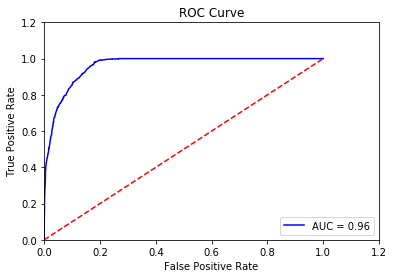

In [355]:
probs = model.predict_proba(dummies)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(train_tgt, preds)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1.2])
plt.ylim([0, 1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Above we have a ROC curve for our Logistic Regression model. We have an ROC value of 0.96, which implies that our model is an extremely good classifier of whether a shot results in a goal or not. This, along with our 90%+ accuracy we found with this model, is a good indication that we picked enough features of a goal. In fact, this further provides evidence that our KNN classifier simply didn't work for some reason.

# Best Location for Shots on Target

We have quite a few features for deciding what constitutes a goal, but which feature is the most dominant factor? A bar graph of all the locations a shot was placed which resulted in a goal will give us a good indicator.

In [383]:
shots_goals = prem[prem['is_goal'] == 1]['shot_place'].value_counts()
shots_nogoals = prem[prem['is_goal'] != 1]['shot_place'].value_counts()

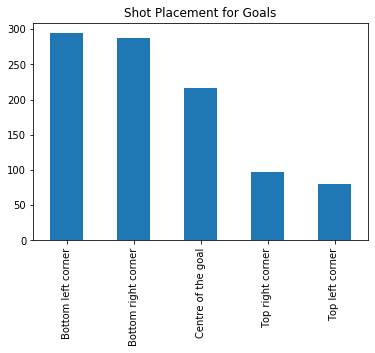

In [385]:
shots_goals.plot(kind = 'bar',  title = 'Shot Placement for Goals')

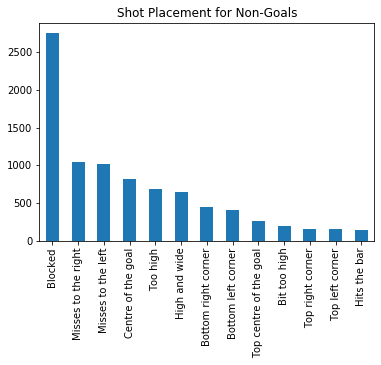

In [386]:
shots_nogoals.plot(kind = 'bar', title = 'Shot Placement for Non-Goals')

Our barplot for shots that resulted in goals suggests that for all shots in the Premier League in the 2015/2016 season that resulted in goals, most of them were placed in the bottom left corner. The next most common location, lagginig not too far behind, was the bottom right corner. In the real world this does make sense because a lot of the time a team's goalkeeper is a tall guy, thus making it harder for him to reach down to the ball. The low-scoring nature of this sport is exemplified by the fact that most of the shots that were not goals were in fact blocked by an opposition player.

# Conclusion

The goal of this project was to determine who ideally would've won the 2015/2016 season based on expected goals. We had enough features to build a model for the overall expected goals for the entire league, but it quickly became apparent that not only would building separate models for each team be time consuming, it still wouldn't give us an adequate answer as we would have to make 380 separate expected goals predictions for each match. We, therefore, did the next best thing. We looked at the features themselves that result in goals. We found that the biggest factor that resulted in a goal was one that was placed in the top right corner. Combining that with the plot for shot placements for goals suggests that it is an extremely rare shot to score off, but when you get it right you're handsomely rewarded. Though we found mistakes with the KNN model, our Logistic Regression model predicted 1169 goals for the league, in comparison to the actual 1026 goals scored.